In [1]:
import qiskit
import itertools

In [2]:
from qiskit import *
from qiskit.quantum_info import Clifford, random_clifford
from qiskit.synthesis import synth_clifford_full
from qiskit.quantum_info import hellinger_fidelity as hf

In [3]:
from pauli_checks import ChecksFinder, add_pauli_checks, add_meas_pauli_checks, add_linear_meas_pauli_checks,  search_for_pauli_list
from pauli_checks import gen_initial_layout, gen_final_layout, complete_postprocess, filter_results

from utils.utils import norm_dict, total_counts
from utils.vqe_utils import evaluation

In [4]:
#creating a 5 qubit random clifford circuit
qubits = 5
total_shots = 100000

In [5]:
rdm_clifford = random_clifford(qubits, seed = 10)

In [6]:
clif_qc = synth_clifford_full(rdm_clifford)

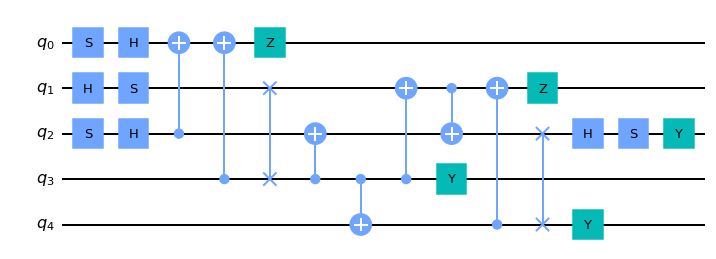

In [7]:
clif_qc.draw("mpl")

In [8]:
characters = ['I', 'Z']
strings = [''.join(p) for p in itertools.product(characters, repeat=qubits)]

In [9]:
test_finder = ChecksFinder(qubits, clif_qc)

In [10]:
p1_list = []
for string in strings:
    string_list = list(string)
    result = test_finder.find_checks_sym(pauli_group_elem = string_list)
    #print(result.p1_str, result.p2_str)
    p1_list.append([result.p1_str, result.p2_str])

In [11]:
sorted_list = sorted(p1_list, key=lambda s: s[1].count('I'))

In [12]:
len(sorted_list)

32

In [13]:
#first find the smallest I count, 

In [14]:
new_list = sorted_list[-qubits -1:-1]
new_list

[['+1IZYIY', '+1IIIIZ'],
 ['+1ZZIII', '+1IIIZI'],
 ['-1XXZII', '+1IIZII'],
 ['-1IIIXI', '+1IZIII'],
 ['+1IZYII', '+1ZIIII']]

In [15]:
sorted_new_list = sorted(new_list, key=lambda s: s[0].count('I'))
sorted_new_list

[['+1IZYIY', '+1IIIIZ'],
 ['-1XXZII', '+1IIZII'],
 ['+1ZZIII', '+1IIIZI'],
 ['+1IZYII', '+1ZIIII'],
 ['-1IIIXI', '+1IZIII']]

In [16]:
sorted_pauli_strings = sorted_new_list[::-1]
sorted_pauli_strings

[['-1IIIXI', '+1IZIII'],
 ['+1IZYII', '+1ZIIII'],
 ['+1ZZIII', '+1IIIZI'],
 ['-1XXZII', '+1IIZII'],
 ['+1IZYIY', '+1IIIIZ']]

In [17]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='anl', project='chm185')
provider.backends()

/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/quantum/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  """Entry point for launching an IPython kernel.
/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/quantum/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with '

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-ornl', group='anl', project='chm185')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-ornl', group='anl', project='chm185')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-ornl', group='anl', project='chm185')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-ornl', group='anl', project='chm185')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-ornl', group='anl', project='chm185')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q-ornl', group='anl', project='chm185')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q-ornl', group='anl', project='chm185')>,
 <IBMQBackend('ibm_hanoi') from IBMQ(hub='ibm-q-ornl', group='anl', project='chm185')>,
 <IBMQBackend('ibm_algiers') from IBMQ(hub='ibm-q-ornl', group='anl', project='chm185')>,
 <IBMQBackend('ibm_cairo') from IBMQ(hub='ibm-q-ornl', group='anl', project='chm185')>,
 <IBMQBackend('ibm_sherbrooke') from IBMQ(hub=

In [18]:
from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer, plot_histogram
from qiskit.compiler import assemble

from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview

import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise import NoiseModel

In [19]:
hanoi_device = provider.get_backend('ibm_hanoi')
hanoi_device

<IBMQBackend('ibm_hanoi') from IBMQ(hub='ibm-q-ornl', group='anl', project='chm185')>

In [20]:
classical_simulator = provider.get_backend('ibmq_qasm_simulator')

In [21]:
prob_1 = 0.003  # 1-qubit gate
prob_2 = 0.03   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3', 'sx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

In [22]:
# noise_model = NoiseModel.from_backend(hanoi_device, gate_error=True, readout_error=True, thermal_relaxation=False)
# print(noise_model)

In [23]:
clif_qc_meas = clif_qc.copy()
clif_qc_meas.measure_active()

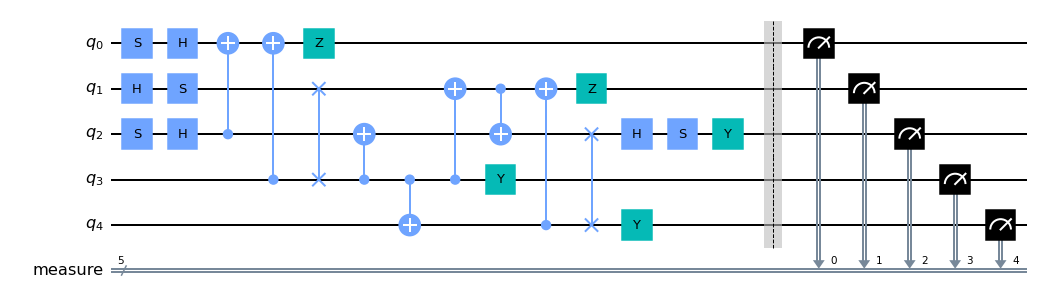

In [24]:
clif_qc_meas.draw(output = 'mpl')

In [25]:
hanoi_qc_meas = transpile(clif_qc_meas, hanoi_device, routing_method = 'sabre', optimization_level = 3, seed_transpiler = 0)

In [26]:
hanoi_qc = hanoi_qc_meas.remove_final_measurements(inplace=False)

In [27]:
#THIS IS THE NOISELESS SIMULATION
job = execute(clif_qc_meas, classical_simulator, shots = total_shots)
job_monitor(job)
results = job.result()
ideal_dist = results.get_counts()

Job Status: job has successfully run


In [28]:
#THIS IS THE NOISY SIMULATION ON IBM_HANOI
noisy_job = execute(hanoi_qc_meas, classical_simulator, noise_model = noise_model, shots = total_shots)
job_monitor(noisy_job)
noisy_results = noisy_job.result()
noisy_dist = noisy_results.get_counts()

Job Status: job has successfully run


In [29]:
hf(norm_dict(noisy_dist), norm_dict(ideal_dist))

0.8689680761992924

In [30]:
sorted_pauli_strings[0][0]

'-1IIIXI'

In [31]:
initial_layout = {}
for i in range(0, qubits):
    initial_layout[i] = [i]
    
final_layout = {}
for i in range(0, qubits):
    final_layout[i] = [i]

In [32]:
sorted_pauli_strings

[['-1IIIXI', '+1IZIII'],
 ['+1IZYII', '+1ZIIII'],
 ['+1ZZIII', '+1IIIZI'],
 ['-1XXZII', '+1IIZII'],
 ['+1IZYIY', '+1IIIIZ']]

In [33]:
len(sorted_pauli_strings)

5

In [34]:
#add pauli check on two sides:
#specify the left and right pauli strings
pl = sorted_pauli_strings[0][0][2:]
pr = sorted_pauli_strings[0][1][2:]
sign = sorted_pauli_strings[0][0][2:]
checked_qc = add_pauli_checks(clif_qc, pl, pr, initial_layout, final_layout, False, False, True, True, True)
        

In [35]:
#add pauli check on two sides:
#specify the left and right pauli strings
pcs_qc_list = []
sign_list = []
pl_list = []
pr_list = []

for i in range(0, len(sorted_pauli_strings)):
    pl = sorted_pauli_strings[i][0][2:]
    pr = sorted_pauli_strings[i][1][2:]
    if i == 0:
        temp_qc = add_pauli_checks(clif_qc, pl, pr, initial_layout, final_layout, False, False, False, True, True)
        save_qc = add_pauli_checks(clif_qc, pl, pr, initial_layout, final_layout, False, False, True, True, True)
        prev_qc = temp_qc
    else:
        temp_qc = add_pauli_checks(prev_qc, pl, pr, initial_layout, final_layout, False, False, False, True, True)
        save_qc = add_pauli_checks(prev_qc, pl, pr, initial_layout, final_layout, False, False, True, True, True) 
        prev_qc = temp_qc
    pl_list.append(pl)
    pr_list.append(pr)
    sign_list.append(sorted_pauli_strings[i][0][:2])
    pcs_qc_list.append(save_qc)

In [36]:
pcs_qc_list[-1].draw()

┌───┐         ░                    ░             ░              »
    q_0: ─────┤ Y ├─────────░────────────────────░─────────────░──────────────»
              └─┬─┘         ░                    ░             ░              »
    q_1: ───────┼───────────░────────────────────░─────────────░──────────────»
                │  ┌───┐    ░                    ░             ░      ┌───┐   »
    q_2: ───────┼──┤ Y ├────░───────■────────────░─────────────░──────┤ Y ├───»
                │  └─┬─┘    ░       │ ┌───┐      ░             ░      └─┬─┘   »
    q_3: ───────┼────┼───■──░───────┼─┤ X ├──────░───────■─────░────────┼───■─»
                │    │   │  ░       │ └─┬─┘┌───┐ ░       │     ░        │   │ »
    q_4: ───────┼────┼───┼──░───────┼───┼──┤ X ├─░───────┼──■──░────────┼───┼─»
                │    │   │  ░       │   │  └─┬─┘ ░       │  │  ░        │   │ »
    q_5: ───────┼────┼───┼──░───────┼───┼────┼───░───────┼──┼──░────────┼───┼─»
                │    │   │  ░       │   │    │   ░       │  │  ░ ┌───┐  │   │ »
    q_6: ───────┼────┼───┼──░───────┼───┼────┼───░───────┼──┼──░─┤ H ├──■───■─»
                │    │   │  ░       │   │    │   ░ ┌───┐ │  │  ░ └───┘        »
    q_7: ───────┼────┼───┼──░───────┼───┼────┼───░─┤ H ├─■──■──░──────────────»
                │    │   │  ░ ┌───┐ │   │    │   ░ └───┘       ░              »
    q_8: ───────┼────┼───┼──░─┤ H ├─■───■────■───░────────────────────────────»
         ┌───┐  │    │   │  ░ └───┘              ░                            »
    q_9: ┤ H ├──■────■───■──░─────────────────────────────────────────────────»
         └───┘              ░                                                 »
IZIII: 1/═════════════════════════════════════════════════════════════════════»
                                                                              »
ZIIII: 1/═════════════════════════════════════════════════════════════════════»
                                                                              »
IIIZI: 1/═════════════════════════════════════════════════════════════════════»
                                                                              »
IIZII: 1/═════════════════════════════════════════════════════════════════════»
                                                                              »
IIIIZ: 1/═════════════════════════════════════════════════════════════════════»
                                                                              »
 meas: 5/═════════════════════════════════════════════════════════════════════»
                                                                              »
«          ░            ░ ┌───┐┌───┐┌───┐┌───┐┌───┐                         »
«    q_0: ─░────────────░─┤ S ├┤ H ├┤ X ├┤ X ├┤ Z ├─────────────────────────»
«          ░      ┌───┐ ░ ├───┤├───┤└─┬─┘└─┬─┘└───┘          ┌───┐     ┌───┐»
«    q_1: ─░──────┤ X ├─░─┤ H ├┤ S ├──┼────┼────X────────────┤ X ├──■──┤ X ├»
«          ░      └─┬─┘ ░ ├───┤├───┤  │    │    │  ┌───┐     └─┬─┘┌─┴─┐└─┬─┘»
«    q_2: ─░────────┼───░─┤ S ├┤ H ├──■────┼────┼──┤ X ├───────┼──┤ X ├──┼──»
«          ░        │   ░ └───┘└───┘       │    │  └─┬─┘       │  ├───┤  │  »
«    q_3: ─░────────┼───░──────────────────■────X────■────■────■──┤ Y ├──┼──»
«          ░        │   ░                               ┌─┴─┐     └───┘  │  »
«    q_4: ─░────────┼───░───────────────────────────────┤ X ├────────────■──»
«          ░ ┌───┐  │   ░                               └───┘               »
«    q_5: ─░─┤ H ├──■───░───────────────────────────────────────────────────»
«          ░ └───┘      ░                                                   »
«    q_6: ─░────────────────────────────────────────────────────────────────»
«          ░                                                                »
«    q_7: ──────────────────────────────────────────────────────────────────»
«                                                                           »
«    q_8: ──────────────────────────────────────

In [37]:
real_job = execute(pcs_qc_list, classical_simulator, noise_model = noise_model, shots = total_shots)
print(real_job.job_id())
job_monitor(real_job)
real_results = real_job.result()
real_dist = real_results.get_counts()

cllpalbrqn01g5tgd2c0
Job Status: job has successfully run


In [38]:
single_side = False
for check_count in range(1, qubits + 1):
    bit_list = ['1' if i == '+1' else '0' for i in sign_list[check_count - 1::-1]]
    meas_pcs_dist = real_dist[check_count - 1]
    if single_side is True:
        output_dict = complete_postprocess(meas_pcs_dist, qubits, check_count, pr_list)
    else:
        output_dict = meas_pcs_dist
    filted_dist = filter_results(output_dict, qubits, [i for i in range(0, check_count)], bit_list)
    print(filted_dist)
    print("check", check_count, hf(norm_dict(filted_dist), norm_dict(ideal_dist)), total_counts(filted_dist))

{'10011': 321, '10111': 319, '10110': 329, '00110': 356, '00011': 320, '01010': 360, '11010': 350, '00111': 324, '00001': 5457, '10101': 5573, '11000': 5522, '01001': 5524, '00010': 325, '11011': 356, '00100': 5606, '01000': 5469, '11001': 5549, '00000': 5532, '10010': 335, '10000': 5497, '00101': 5544, '11100': 5580, '10100': 5769, '01101': 5557, '11111': 348, '10001': 5570, '01011': 336, '01110': 318, '11101': 5523, '01111': 346, '11110': 352, '01100': 5498}
check 1 0.9426343500496764 94165
{'10110': 162, '11011': 179, '00011': 178, '01110': 196, '10001': 5409, '11111': 156, '00100': 5365, '01011': 165, '10000': 5331, '01010': 199, '01001': 5415, '01000': 5352, '10101': 5301, '11000': 5356, '11101': 5436, '00001': 5490, '10100': 5418, '00111': 162, '01101': 5444, '11001': 5273, '11100': 5322, '01100': 5390, '11110': 174, '00101': 5323, '00000': 5298, '00110': 173, '01111': 162, '11010': 168, '00010': 164, '10111': 148, '10011': 171, '10010': 173}
check 2 0.9691602793443033 88653
{'00